In [2]:
import pandas as pd
import numpy as np
import random
import math
import timeit
import itertools
import warnings
import pickle
import feather
import gc
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join, isfile
from collections import Counter
from fcmeans import FCM
import scipy.stats as stats
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, classification_report, mutual_info_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.2f}".format(x)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
mainPath = "../../data"
beacons = join(mainPath, "beacon")
testSets = join(beacons, "testsets")
models = join(mainPath, "models")
ceuPath = join(beacons, "CEU")
opensnpPath = join(beacons, "OpenSNP")

#### STEP 1: Load Beacon, MAF, Reference and other cached variables

In [4]:
features = [ 'EyeColor','HairType','HairColor','TanAbility','Asthma','LactoseIntolerance',#'BloodType',
             'EarWax','Freckling','TongueRoller','RingFinger','Intolerance','WidowPeak','ADHD','Acrophobia',
             'FingerHair','Myopia','IrritableBowel','IndexLongerBig','Photoptarmis','Migraine','RhProtein']
with open(join(opensnpPath, "OpenSNP_Phenotype.pickle"), 'rb') as handle:
    pheno = pickle.load(handle)
pheno = pheno[features]
pheno[pheno=="Auburn"] = "Blonde"
pheno[pheno=="Black"] = "Brown"

with open(join(opensnpPath, "MAF.pickle"), 'rb') as handle:
    maf = pickle.load(handle)

with open(join(opensnpPath, "Reference.pickle"), 'rb') as handle:
    reference = pickle.load(handle)
reference = reference.values

with open(join(opensnpPath, "Beacon.pickle"), 'rb') as handle:
    beacon = pickle.load(handle)

with open(join(opensnpPath, "BinaryBeacon.pickle"), 'rb') as handle:
    binary = pickle.load(handle)
    
with open(join(opensnpPath, "TernaryBeacon.pickle"), 'rb') as handle:
    ternary = pickle.load(handle)

In [5]:
ternary

array([[ 0,  0, -1, ..., -1,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0, -1, ..., -1,  1, -1],
       ...,
       [ 0,  0,  0, ...,  1,  1,  0],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

In [6]:
beacon

,6855,740,1775,2006,7958,6220,2983,2296,2570,5555,...,6786,6906,4741,4582,7634,7505,1706,6206,5201,6084
rs_id,,,,,,,,,,,,,,,,,,,,,
rs10,CC,CC,NN,NN,NN,NN,CC,NN,NN,NN,...,AC,NN,CC,NN,NN,NN,NN,NN,CC,NN
rs1000000,GG,GG,GG,GG,NN,GG,AA,GG,GG,GG,...,GG,GG,AG,GG,NN,NN,GG,GG,GG,GG
rs10000010,CT,TT,NN,NN,NN,NN,CT,NN,NN,NN,...,CT,NN,CC,NN,NN,NN,NN,NN,CT,NN
rs10000012,NN,NN,NN,NN,NN,NN,NN,NN,NN,NN,...,NN,NN,NN,NN,NN,NN,NN,NN,NN,NN
rs1000002,TT,CT,NN,NN,CC,NN,CT,NN,NN,NN,...,CC,NN,CC,NN,NN,CT,NN,NN,TT,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9999978,NN,NN,NN,NN,NN,NN,NN,NN,NN,NN,...,NN,NN,NN,NN,NN,NN,NN,NN,NN,NN
rs9999979,CT,CC,TT,TT,NN,CC,CT,TT,NN,CT,...,TT,CC,CC,CT,NN,NN,CC,CC,CT,CC
rs9999992,GG,GG,GG,GG,NN,AG,GG,GG,AG,GG,...,GG,GG,GG,GG,NN,NN,GG,AG,AG,GG


#### Constrainted Indices

In [4]:
pheno5People = pheno.iloc[np.where(np.sum(pheno != "-", axis = 1) >=10)[0]].index
pheno5People = pheno5People.map(str)
pheno5People = np.where(beacon.columns.isin(pheno5People))[0]

pheno1People = pheno.iloc[np.where(np.sum(pheno != "-", axis = 1) >= 1)[0]].index
pheno1People = pheno1People.map(str)
pheno1People = np.where(beacon.columns.isin(pheno1People))[0]

phenoAllPeople = np.arange(beacon.shape[1])

#### STEP 1.2: PCA and Clustering 

Counter({1: 668, 0: 536, 2: 116})
[[517.16 18.28 0.50 -2.28]
 [-343.34 -188.36 2.14 1.20]
 [-412.45 1000.26 -14.64 3.62]]
CPU times: user 4min 19s, sys: 14.6 s, total: 4min 34s
Wall time: 56.6 s


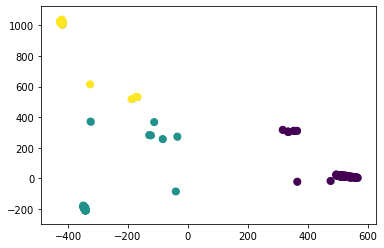

In [6]:
pca = PCA(n_components=4)
tr1 = pca.fit_transform(ternary[:, pheno1People].T)
plt.scatter(tr1[:, 0], tr1[:, 1], alpha=0.4)

kmeans = KMeans(3)
y_kmeans = kmeans.fit_predict(tr1)
plt.scatter(tr1[:, 0], tr1[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
print(Counter(y_kmeans))
print(centers)

In [7]:
# Get indices of homogeneous groups
g1 = pheno1People[np.where(y_kmeans == 0)[0]]
g2 = pheno1People[np.where(y_kmeans == 1)[0]]
g3 = pheno1People[np.where(y_kmeans == 2)[0]]
print(g1.shape, g2.shape, g3.shape)

g1a = np.intersect1d(g1, pheno5People)
g2a = np.intersect1d(g2, pheno5People)
g3a = np.intersect1d(g3, pheno5People)
print(g1a.shape, g2a.shape, g3a.shape)

(536,) (668,) (116,)
(94,) (60,) (5,)


#### STEP 1.2: Function Definitions

In [8]:
# Beacon operations
def queryBeacon(beacon_people):
    return binary[:, beacon_people].any(axis=1)

def getMutationAt(index):
    temp = maf.iloc[index]
    if temp["minor_freq"] == temp["maf"]:
        return temp["minor"] + temp["minor"] 
    else:
        return temp["major"] + temp["major"] 

def div(n, d):
    return n / d if d else 0

def rpaCalculate(tp,fp,tn,fn):
    recall = div(tp,(tp+fn)) 
    precision = div(tp,(tp+fp))
    accuracy = div((tp+tn),(tp+fp+tn+fn))
    return recall, precision, accuracy

def getTrainingData(phenotype, pos, test_people):
    # Find indices of people who has the specified feature
    feature_label = pheno[pheno[phenotype] != "-"][phenotype]
    existing = beacon.columns.isin(feature_label.index.values)
    existing[test_people] = False 
    
    # Get training data
    X = binary[pos][:, existing].T
    Y = feature_label[beacon.columns[existing]].values
    return X, Y

# Performance method
def performance(person, reconstruction, eval_pos, reference):
    ind = np.logical_and(person[eval_pos] != np.squeeze(reference)[eval_pos], person[eval_pos] != "NN")
    tp = np.sum(reconstruction[eval_pos][ind] != np.squeeze(reference)[eval_pos][ind])
    fn = np.sum(ind) - tp
    fp = np.sum(reconstruction[eval_pos][~ind] != np.squeeze(reference)[eval_pos][~ind])
    tn = np.sum(~ind) - fp
    return tp, fp, tn, fn

def performance_f(test_people, reconstructed, add_count, cluster_count, eval_pos):
    total_values = np.zeros((4))
    best_matches = []
    # For all people in victim set
    for i in range(add_count):
        all_combinations = np.zeros((4, cluster_count))
        rpa = np.zeros((3, cluster_count))
        # For each cluster obtained
        for j in range(cluster_count):
            all_combinations[:, j] = performance(test_people[i], reconstructed[j], eval_pos, reference)
            rpa[:, j] = rpaCalculate(*all_combinations[:, j])
        ind = np.argmax(rpa[0,:]*rpa[1,:])       #Best-match index
        best_matches.append(ind)
        total_values += all_combinations[:, ind] #Add total tp-fp-tn-fn
    recall, precision, accuracy = rpaCalculate(*total_values)
    print("Recall_Micro_Avg    =", round(recall, 2),"\nPrecision_Micro_Avg =", round(precision, 2))
    return (precision,recall,accuracy), total_values, best_matches

#### STEP 2: Choose random people and send query to Beacon to obtain No-Yes answers

In [98]:
def getNoYes(add_count, beacon_size):

    # Take people for added group
    random.shuffle(g1a)
    random.shuffle(g2a)
    random.shuffle(g3a)
    if add_count >= 5:
        added_people = np.concatenate([g1a[:(2*add_count//5)], g2a[:(2*add_count//5)], g3a[:(add_count//5)]])
    elif add_count == 3:
        added_people = np.concatenate([g1a[:(add_count//3)], g2a[:(add_count//3)], g3a[:(add_count//3)]])
    elif add_count == 2:
        added_people = np.concatenate([g1a[:(add_count//2)], g2a[:(add_count//2)]])
        
    # Take people for beacon
    g1_ = np.setdiff1d(g1, g1a)
    random.shuffle(g1_)
    g2_ = np.setdiff1d(g2, g2a)
    random.shuffle(g2_)
    g3_ = np.setdiff1d(g3, g3a)
    random.shuffle(g3_)
    if add_count >= 5:
        curBeacon = np.concatenate([g1_[:(2*beacon_size//5)], g2_[:(2*beacon_size//5)], g3_[:(beacon_size//5)]])
    elif add_count == 3:
        curBeacon = np.concatenate([g1_[:(beacon_size//3)], g2_[:(beacon_size//3)], g3_[:(beacon_size//3)]])
    elif add_count == 2:
        curBeacon = np.concatenate([g1_[:(beacon_size//2)], g2_[:(beacon_size//2)]])
        
    
    # Query Beacon initially
    before = queryBeacon(curBeacon)
    # Add people
    updatedBeacon = np.concatenate([added_people,curBeacon])
    # Query Beacon again
    after = queryBeacon(updatedBeacon)
    # Find No-Yes SNPs' indices
    no_yes_indices = np.where(np.logical_and(before==False, after==True))[0]
    yes_yes_indices = np.where(np.logical_and(before==True, after==True))[0]
    print("Number of No-Yes SNP's : ", len(no_yes_indices))
    
    return yes_yes_indices, no_yes_indices, added_people

In [10]:
def getNoYes2(add_count, beacon_size):

    # Take people for added group
    added_people = pheno5People.copy()
    random.shuffle(added_people)
    added_people = added_people[:add_count]
    
    # Take people for beacon
    beacon_people = np.setdiff1d(phenoAllPeople, added_people)
    random.shuffle(beacon_people)
    beacon_people = beacon_people[:beacon_size]

    # Query Beacon initially
    before = queryBeacon(beacon_people)
    # Add people
    updated_beacon = np.concatenate([added_people,beacon_people])
    # Query Beacon again
    after = queryBeacon(updated_beacon)
    # Find No-Yes SNPs' indices
    no_yes_indices = np.where(np.logical_and(before==False, after==True))[0]
    yes_yes_indices = np.where(np.logical_and(before==True, after==True))[0]
    print("Number of No-Yes SNP's : ", len(no_yes_indices))
    
    return yes_yes_indices, no_yes_indices, added_people

#### STEP 3: Correlation Model

In [11]:
def builtSNPNetwork(no_yes_indices, model_ind, reference):
    model = ternary[no_yes_ind][:, model_ind].astype(float)
    model[model==-1] = np.nan
    x = pairwise_distances(model, metric = "sokalmichener", n_jobs=-1)
    x = 1-np.nan_to_num(x)
    return x

In [132]:
def baseline_method(no_yes_indices, add_count, cluster_count=None):
    c = maf.iloc[no_yes_indices]

    # Calculate probabilities of SNP possibilities
    greater = c.loc[c['major_freq'] >= c['minor_freq']]
    smaller = c.loc[c['major_freq'] < c['minor_freq']]

    greater["maj-maj"] = greater['major'] + "" + greater['major']
    greater["mean"] = pd.concat([greater['major'] + "" + greater['minor'], greater['minor'] + "" + greater['major']], axis=1).min(axis=1)
    greater["min-min"] = greater['minor'] + "" + greater['minor']
    greater["p1"] = greater['major_freq']**2
    greater["p2"] = 2*greater['major_freq']*greater['minor_freq']
    greater["p3"] = greater['minor_freq']**2

    smaller["maj-maj"] = smaller['minor'] + "" + smaller['minor']
    smaller["mean"] = pd.concat([smaller['major'] + "" + smaller['minor'], smaller['minor'] + "" + smaller['major']], axis=1).min(axis=1)
    smaller["min-min"] = smaller['major'] + "" + smaller['major']
    smaller["p1"] = smaller['minor_freq']**2
    smaller["p2"] = 2*smaller['major_freq']*smaller['minor_freq']
    smaller["p3"] = smaller['major_freq']**2

    tt = pd.concat([greater,smaller], axis=0)
    tt.sort_index(inplace=True)

    genome_possibilities = tt[["maj-maj", "mean", "min-min"]].values
    probabilities = tt[["p1","p2","p3"]].values

    mutations = tt[["mean", "min-min"]].values
    mutation_probs = tt[["p2","p3"]].values

    # Randomly reconstruct the people's genome
    bins = []
    cumulative = probabilities.cumsum(axis=1)
    for i in range(add_count):
        uniform = np.random.rand(len(cumulative), 1)
        choices = (uniform < cumulative).argmax(axis=1)
        reconstructed = np.choose(choices, genome_possibilities.T)
        bins.append(reconstructed)
    bins = np.array(bins)
    
    # Be sure that at least one person has the mutation
    equality = np.sum((bins == reference[no_yes_indices].T), axis=0)
    changed_indices = np.where(equality==add_count)[0]

    index_choices = np.random.randint(add_count, size=len(equality))[changed_indices]

    non_zeros = mutation_probs[np.sum(mutation_probs, axis=1) != 0]
    probs = (non_zeros.T / np.sum(non_zeros, axis=1).T).T

    zeros = np.zeros((mutation_probs.shape[0], 2))
    zeros[np.sum(mutation_probs, axis=1) != 0] = probs
    probs = zeros[changed_indices]

    cum = probs.cumsum(axis=1)
    uni = np.random.rand(len(cum), 1)
    choi = (uni < cum).argmax(axis=1)
    res = np.choose(choi, mutations[changed_indices].T)

    bins.T[changed_indices, index_choices] = res
    # Reconstruct
    reconstructed = np.array([reference.T[0] for i in range(add_count)])
    reconstructed.T[no_yes_indices] = bins.T
    return reconstructed

##### Spectral Clustering

In [12]:
def spectralClustering(no_yes_indices, add_count, x, reference, cluster_count=None):
    if not cluster_count:
        cluster_count = add_count
    sc = SpectralClustering(cluster_count, affinity='precomputed', n_init=100, n_jobs=-1)
    sc.fit(np.array(x))
    bins = []
    for i in range(cluster_count):
        temp = []
        for element in np.where(sc.labels_==i)[0]:
            temp.append(no_yes_indices[element])
        #print("Bin " + str(i) + " has " + str(len(temp)) + " SNP's")
        bins.append(temp)
    reconstructed = np.array([reference.T[0] for i in range(cluster_count)])
    for i in range(cluster_count):
        for j in bins[i]:
            reconstructed[i][j] = getMutationAt(j)
    return reconstructed

#### Fuzzy Clustering

In [13]:
def fuzzyClustering(no_yes_indices, add_count, x, reference, cluster_count=None):
    if not cluster_count:
        cluster_count = add_count
    fcm = FCM(n_clusters=cluster_count)
    fcm.fit(correlations)
    soft_clusters = fcm.u
    bins = [[] for i in range(cluster_count)]
    for i in range(len(soft_clusters)):
        maxPos = np.argmax(soft_clusters[i])
        if soft_clusters[i][maxPos] <= 0.5:
            for j in np.where(soft_clusters[i] > (soft_clusters[i][maxPos] * 2 / 3))[0]:
                bins[j].append(no_yes_indices[i])
        else:
            bins[maxPos].append(no_yes_indices[i])
    reconstructed = np.array([reference.T[0] for i in range(cluster_count)])
    for i in range(cluster_count):
        for j in bins[i]:
            reconstructed[i][j] = getMutationAt(j)
    return reconstructed

## Genome Reconstruction

In [126]:
add_count = 2
cluster_count = 2
beacon_size = 50
yes_yes_ind, no_yes_ind, added_people     = getNoYes(add_count, beacon_size)

Number of No-Yes SNP's :  6274


In [127]:
model_ind = np.setdiff1d(pheno1People, added_people)
correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
(precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,cluster_count,no_yes_ind)

Recall_Micro_Avg    = 0.94 
Precision_Micro_Avg = 0.95
CPU times: user 57.5 s, sys: 1.16 s, total: 58.7 s
Wall time: 6.19 s


## All Tests and Plots

In [ ]:
experiments = [(2,20),(3,30),(4,40),(5,50),(10,100),(20,100)]
res = []
for e in experiments:
    add_count = e[0]
    beacon_size = e[1]

    for i in range(20):
        yes_yes_ind, no_yes_ind, added_people = getNoYes(add_count, beacon_size)
        model_ind = np.setdiff1d(pheno1People, added_people)

        # Genome Reconstruction    
        correlations                              = builtSNPNetwork(no_yes_ind, model_ind, reference)
        reconstructed_spectral                    = spectralClustering(no_yes_ind, add_count, correlations, reference)
        (precision,recall,accuracy), _, matches   = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,add_count,no_yes_ind)

## Experiment 1: Vary Added People

In [130]:
counts = [2,3,5,10,20]
beacon_size = 50
run_count = 20

results = np.zeros((3, len(counts), run_count, 3))

for i in range(len(counts)):
    for j in range(run_count):
        yes_yes_ind, no_yes_ind, added_people = getNoYes(counts[i], beacon_size)
        model_ind = np.setdiff1d(pheno1People, added_people)

        # Genome Reconstruction    
        correlations                = builtSNPNetwork(no_yes_ind, model_ind, reference)
        reconstructed_spectral      = spectralClustering(no_yes_ind, counts[i], correlations, reference)
        results[0, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,counts[i],counts[i],no_yes_ind) 


        # Baseline
        reconstructed_baseline      = baseline_method(no_yes_ind, counts[i])
        results[1, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_baseline,counts[i],counts[i],no_yes_ind)  

        # Fuzzy
        reconstructed_fuzzy         = fuzzyClustering(no_yes_ind, counts[i], correlations, reference)
        results[2, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_fuzzy, counts[i], counts[i], no_yes_ind)  
        
with open("1F-Triple-VaryAdded.pickle", 'wb') as file:
    pickle.dump(results, file)

Number of No-Yes SNP's :  1032
Recall_Micro_Avg    = 0.86 
Precision_Micro_Avg = 0.87
(2, 1032)
(2, 1032)
Recall_Micro_Avg    = 0.52 
Precision_Micro_Avg = 0.5
Recall_Micro_Avg    = 0.87 
Precision_Micro_Avg = 0.88


## Experiment 2: Vary Beacon Size

In [ ]:
counts = [25,50,75,100]
add_count = 5
run_count = 20

results = np.zeros((3, len(counts), run_count, 3))

for i in range(len(counts)):
    for j in range(run_count):
        yes_yes_ind, no_yes_ind, added_people = getNoYes(add_count, counts[i])
        model_ind = np.setdiff1d(pheno1People, added_people)

        # Genome Reconstruction    
        correlations                = builtSNPNetwork(no_yes_ind, model_ind, reference)
        reconstructed_spectral      = spectralClustering(no_yes_ind, add_count, correlations, reference)
        results[0, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,add_count,no_yes_ind) 


        # Baseline
        reconstructed_baseline      = baseline_method(no_yes_ind, add_count)
        results[1, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_baseline,add_count,add_count,no_yes_ind)  

        # Fuzzy
        reconstructed_fuzzy         = fuzzyClustering(no_yes_ind,add_count,correlations,reference)
        results[2, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_fuzzy,add_count,add_count,no_yes_ind)  
        
with open("1F-Triple-VaryBeacon.pickle", 'wb') as file:
    pickle.dump(results, file)

## Experiment 3: Cluster Count

In [ ]:
counts = [1,2,3,4,5,10]
add_count = 5
run_count = 20
beacon_size = 50

results = np.zeros((3, len(counts), run_count, 3))

for i in range(len(counts)):
    for j in range(run_count):
        yes_yes_ind, no_yes_ind, added_people = getNoYes(add_count, beacon_size)
        model_ind = np.setdiff1d(pheno1People, added_people)

        # Genome Reconstruction    
        correlations                = builtSNPNetwork(no_yes_ind, model_ind, reference)
        reconstructed_spectral      = spectralClustering(no_yes_ind, add_count, correlations, reference)
        results[0, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T,reconstructed_spectral,add_count,counts[i],no_yes_ind) 


        # Baseline
        reconstructed_baseline      = baseline_method(no_yes_ind, add_count)
        results[1, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_baseline,add_count,counts[i],no_yes_ind)  

        # Fuzzy
        reconstructed_fuzzy         = fuzzyClustering(no_yes_ind,add_count,correlations,reference)
        results[2, i, j, :],_,_     = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_fuzzy,add_count,counts[i],no_yes_ind)  
        
with open("1F-Triple-VaryCluster.pickle", 'wb') as file:
    pickle.dump(results, file)